In [25]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
import xgboost as xgb

#### Import Data

In [4]:
test_df = pd.read_csv("./data/test_data.csv")
train_df = pd.read_csv("./data/train_data.csv")

In [5]:
train_df.head(5)

,Review,Recommended
0,"""go to"" please offer a maxi for mature custome...",1
1,"""go to"" tee for sz 10+ women.Women who want so...",1
2,"""long and warm"".These leg warmers are perfect ...",1
3,"""tweed"" dress.I bought this dress for my siste...",1
4,#1 stunna.I am in lust with this fabulous dres...,1


In [6]:
train_df.shape

(16985, 2)

In [7]:
test_df.head(5)

,Review,Recommended
0,"""beach business"".Great for the beachy business...",1
1,"""formal pajamas"".These are super comfy and so ...",1
2,"""perfect with jeans"".Great with leggings.perfe...",1
3,"""won't stretch"" tags are misleading.The tag on...",1
4,$200 piece of polyester.A $200 piece of polyes...,0


In [8]:
test_df.shape

(5657, 2)

In [9]:
X_train, y_train, X_val, y_val = train_df['Review'], train_df['Recommended'], test_df['Review'], test_df['Recommended'],

In [20]:
# remove the single stopwords.
# N-grams that include stopwords will be kept in the corpus as they can enlarge the model’s predictive capability.
# For more detail, see https://rstudio-pubs-static.s3.amazonaws.com/96252_bd61a0777ad44d04b619ce95ca44219c.html
def text_vectorizer(X, ngram_range=(1,1)):
    vect = TfidfVectorizer(ngram_range=ngram_range ,min_df=5, norm=None,  stop_words="english").fit(X)
    X = vect.transform(X)
    return X

In [12]:
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['already', 'becomes', 'while', 'most', 'during', 'him', 'themselves', 'there', 'see', 'through', 'whose', 'more', 'whatever', 'such', 'once', 'two', 'between', 'at', 'other', 'upon', 'ie', 'although', 'perhaps', 'was', 'or', 'all', 'afterwards', 'from', 'nor', 'cannot', 'amongst', 'few']


In [21]:
X_train1 = text_vectorizer(X_train, ngram_range=(1,3))
X_val1 = text_vectorizer(X_val, ngram_range=(1,3))

#### TfidfVectorizer+ Bag of words with more than one word (n-grams) + Limit vocabulary to meaningful words by deleting Stop-words + Logistic Regression

In [67]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(class_weight='balanced', solver = 'liblinear'), param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train1, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.94
Best parameters:
{'C': 0.001, 'penalty': 'l2'}


In [71]:
logi = LogisticRegression(C=0.001, penalty = 'l2', class_weight='balanced', solver = 'liblinear').fit(X_val1, y_val)
y_pred = logi.predict(X_val1) 
print("Test cross-validation score: {:.2f}".format(np.mean(cross_val_score(logi, X_val1, y_val, scoring = 'roc_auc'))))

Test cross-validation score: 0.92


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [72]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1026
           1       0.99      0.92      0.96      4631

    accuracy                           0.93      5657
   macro avg       0.86      0.94      0.90      5657
weighted avg       0.94      0.93      0.93      5657



In [11]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

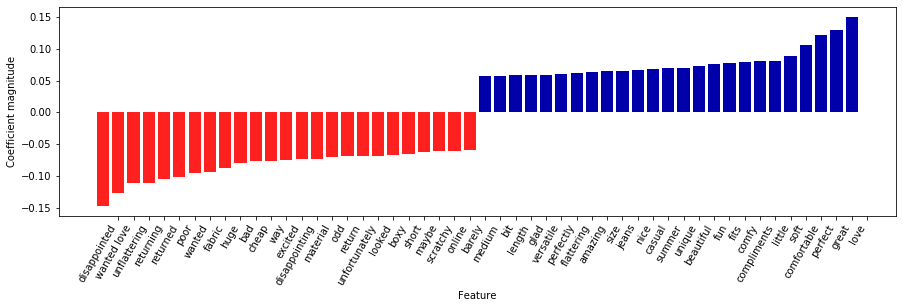

In [85]:
coefs = logi.coef_
vect = TfidfVectorizer(ngram_range=(1,3) ,min_df=5, norm=None, stop_words="english").fit(X_val)
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=25)

#### TfidfVectorizer+ Bag of words with more than one word (n-grams) + Limit vocabulary to meaningful words by deleting Stop-words + RandomForest

In [80]:
param_grid = {'max_features': ['sqrt', 'log2', None], 'bootstrap': [True, False]}
grid = GridSearchCV(RandomForestClassifier(n_estimators = 100, class_weight='balanced_subsample', n_jobs = -1), param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train1, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.93
Best parameters:
{'bootstrap': False, 'max_features': 'log2'}


In [81]:
rf = RandomForestClassifier(max_features = 'log2', bootstrap = False, n_estimators = 100, class_weight='balanced', n_jobs = -1).fit(X_val1, y_val)
y_pred = logi.predict(X_val1) 
print("Test cross-validation score: {:.2f}".format(np.mean(cross_val_score(rf, X_val1, y_val, scoring = 'roc_auc'))))

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Test cross-validation score: 0.91


In [82]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1026
           1       0.99      0.92      0.96      4631

    accuracy                           0.93      5657
   macro avg       0.86      0.94      0.90      5657
weighted avg       0.94      0.93      0.93      5657



#### TfidfVectorizer+ Bag of words with more than one word (n-grams) + Limit vocabulary to meaningful words by deleting Stop-words + XGboost

In [36]:
param_grid = {
    "eta": [0.05, 0.1, 0.2, 0.3], 
    "subsample": [0.5],
    "gamma": [0, 0.5]
}
grid = GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight = 1), param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train1, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.90
Best parameters:
{'eta': 0.05, 'gamma': 0.5, 'subsample': 0.5}


In [37]:
sgbc = xgb.XGBClassifier(eta = 0.05, subsample =0.5, gamma = 0.3, objective="binary:logistic", random_state=42, scale_pos_weight = 1).fit(X_val1, y_val)
y_pred = sgbc.predict(X_val1) 
print("Test cross-validation score: {:.2f}".format(np.mean(cross_val_score(sgbc, X_val1, y_val, scoring = 'roc_auc'))))

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Test cross-validation score: 0.88


In [38]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.42      0.57      1026
           1       0.89      0.99      0.93      4631

    accuracy                           0.89      5657
   macro avg       0.88      0.71      0.75      5657
weighted avg       0.88      0.89      0.87      5657



#### TfidfVectorizer+ Bag of words with more than one word (n-grams) + Limit vocabulary to meaningful words by deleting Stop-words + SVM

In [40]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ['linear', 'rbf']
}
grid = GridSearchCV(svm.SVC(class_weight='balanced', gamma = 'auto'), param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train1, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.93
Best parameters:
{'C': 1, 'kernel': 'rbf'}


In [42]:
svmc = svm.SVC(class_weight='balanced').fit(X_val1, y_val)
y_pred = svmc.predict(X_val1) 
print("Test cross-validation score: {:.2f}".format(np.mean(cross_val_score(sgbc, X_val1, y_val, scoring = 'roc_auc'))))

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Test cross-validation score: 0.88


In [43]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      1026
           1       0.99      0.91      0.95      4631

    accuracy                           0.92      5657
   macro avg       0.85      0.94      0.88      5657
weighted avg       0.94      0.92      0.93      5657



#### TfidfVectorizer+ Bag of words with more than one word (n-grams) + Limit vocabulary to meaningful words by deleting Stop-words + Ridge Logistic Regression approaches the best performance. 